In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import sys
sys.path.append(os.path.abspath('..'))

In [3]:
from utils.preprocess import preprocess_pipeline
from cnn.cnn_model import CustomCNN

from features.statistics import compute_stats
from rules.decision_rules import classify
from segmentation.patch_segmenter import segment_image

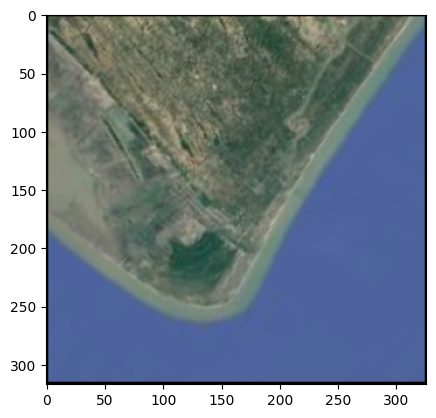

In [5]:
path = "../data/coastline/5.png"
img = cv2.imread(path)
image = preprocess_pipeline(path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

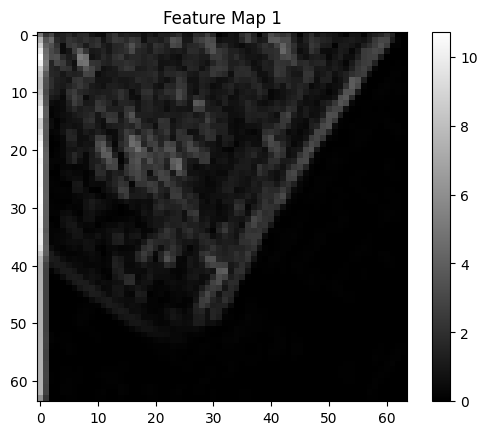

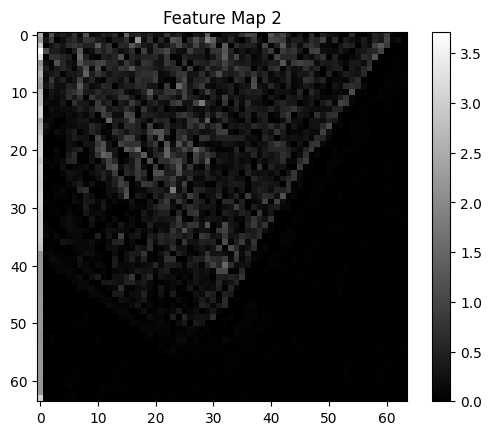

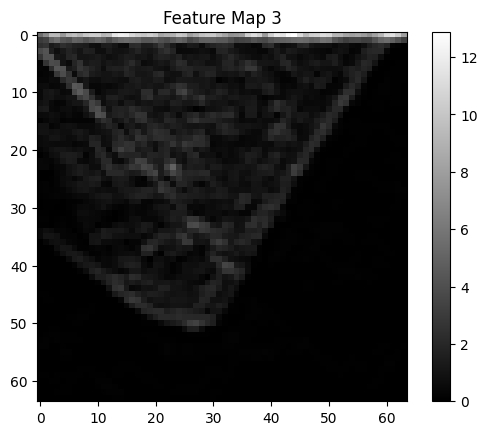

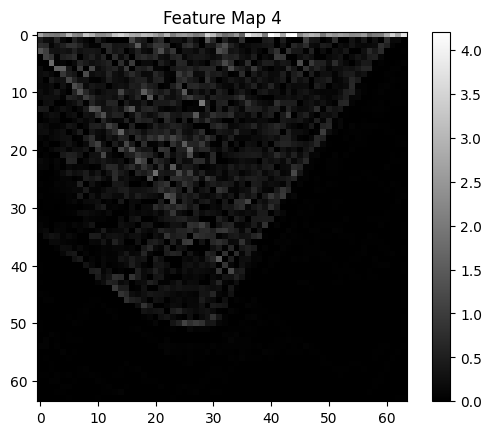

In [39]:
model = CustomCNN()
output = model.forward(image)

for i in range(len(output)):
    plt.figure()
    plt.title(f"Feature Map {i+1}")
    plt.imshow(output[i], cmap='gray')
    plt.colorbar()
    plt.show()

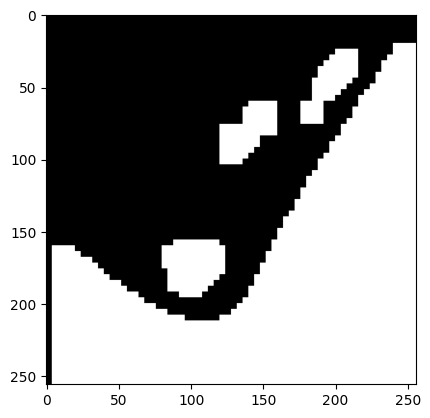

In [40]:
mask = segment_image(image, model)
plt.imshow(mask, cmap='gray')
plt.show()

In [6]:
def collect_patch_stats(image, model, patch_size=16, stride=4):

    h, w = image.shape

    means = []
    variances = []

    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):

            patch = image[i:i+patch_size, j:j+patch_size]
            feature_maps = model.forward(patch)

            mean_val, var_val = compute_stats(feature_maps)

            means.append(mean_val)
            variances.append(var_val)

    return np.array(means), np.array(variances)

In [7]:
means, variances = collect_patch_stats(image, model)

In [31]:
np.median(means)

np.float64(1.4681372493505478)

In [32]:
T_mean = np.median(means)

In [33]:
water_idx = means < T_mean
land_idx = means >= T_mean

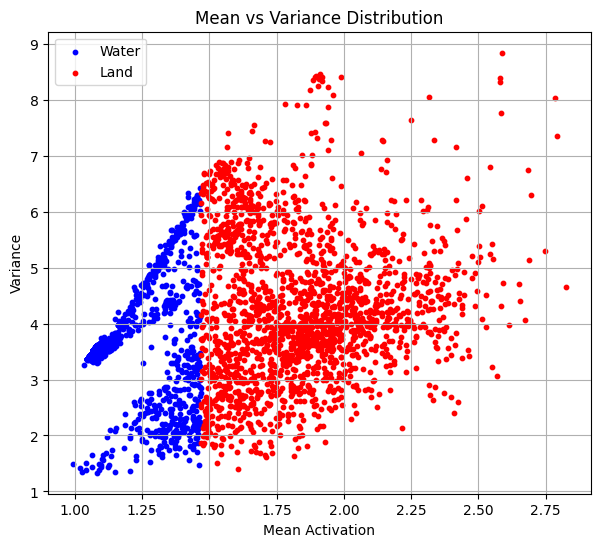

In [34]:
plt.figure(figsize=(7,6))

plt.scatter(means[water_idx],
            variances[water_idx],
            c='blue',
            s=10,
            label='Water')

plt.scatter(means[land_idx],
            variances[land_idx],
            c='red',
            s=10,
            label='Land')

plt.xlabel("Mean Activation")
plt.ylabel("Variance")
plt.title("Mean vs Variance Distribution")
plt.legend()
plt.grid(True)

plt.show()

In [41]:
mask = mask.astype(np.uint8)

In [42]:
contours, _ = cv2.findContours(mask,
                               cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_SIMPLE)

In [43]:
output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

In [44]:
output = cv2.drawContours(output, contours, -1, (0,0,255), 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


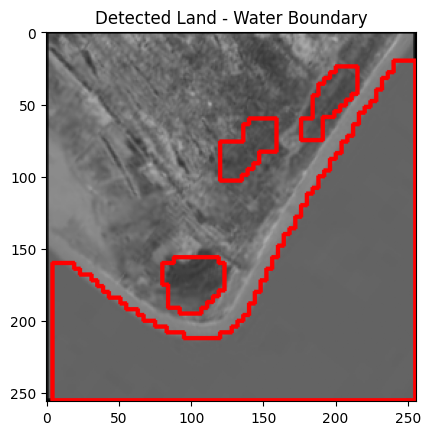

In [45]:
plt.imshow(output[:,:,::-1])
plt.title("Detected Land - Water Boundary")
plt.show()